In [2]:
# importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
import kagglehub

# Set display and plotting styles
pd.set_option('display.max_rows', None)
sns.set_style('darkgrid')


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download latest version
path = kagglehub.dataset_download("mohdsharik/sensor-sourse-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sensor-sourse-data


In [4]:
# reading 10min level data
sensor_df10m = pd.read_csv('/kaggle/input/sensor-sourse-data/sensor_df10m.csv')

In [5]:
# reading first 5 records
sensor_df10m.head()

,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor
0,2021-05-26 13:00:00,119.993750,104.962500,59.993750,47.500000,0.881875
1,2021-05-26 13:10:00,120.020540,97.928895,59.969136,47.507397,0.864791
2,2021-05-26 13:20:00,120.019424,97.775872,59.960309,47.523690,0.864258
3,2021-05-26 13:30:00,120.016662,97.750659,59.966538,47.540000,0.864011
4,2021-05-26 13:40:00,120.026570,98.090260,59.971062,47.555500,0.865002


In [6]:
# setting the Server_Date data type to datetime type
sensor_df10m['Server_Date'] = pd.to_datetime(sensor_df10m['Server_Date'])

In [7]:
# creating new features that will be helpful for power predition
sensor_df10m['sin_hour'] = np.sin(2 * np.pi * sensor_df10m['Server_Date'].dt.hour / 24)  
sensor_df10m['day'] = sensor_df10m['Server_Date'].dt.day
sensor_df10m['day_of_week'] = sensor_df10m['Server_Date'].dt.dayofweek 

In [8]:
# reading first 5 records
sensor_df10m.head()

,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor,sin_hour,day,day_of_week
0,2021-05-26 13:00:00,119.993750,104.962500,59.993750,47.500000,0.881875,-0.258819,26,2
1,2021-05-26 13:10:00,120.020540,97.928895,59.969136,47.507397,0.864791,-0.258819,26,2
2,2021-05-26 13:20:00,120.019424,97.775872,59.960309,47.523690,0.864258,-0.258819,26,2
3,2021-05-26 13:30:00,120.016662,97.750659,59.966538,47.540000,0.864011,-0.258819,26,2
4,2021-05-26 13:40:00,120.026570,98.090260,59.971062,47.555500,0.865002,-0.258819,26,2


## Shifting target variable

In [9]:
# In order to predict future we will have to train model on 1 hour future data (power)
sensor_df10m['Power'] = sensor_df10m['Power'].shift(-6)

In [10]:
# first few samples after 6 shifts (60 mins shift)
sensor_df10m.head(10)


,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor,sin_hour,day,day_of_week
0,2021-05-26 13:00:00,119.993750,101.921487,59.993750,47.500000,0.881875,-0.258819,26,2
1,2021-05-26 13:10:00,120.020540,115.386556,59.969136,47.507397,0.864791,-0.258819,26,2
2,2021-05-26 13:20:00,120.019424,102.378651,59.960309,47.523690,0.864258,-0.258819,26,2
3,2021-05-26 13:30:00,120.016662,95.869542,59.966538,47.540000,0.864011,-0.258819,26,2
4,2021-05-26 13:40:00,120.026570,96.064477,59.971062,47.555500,0.865002,-0.258819,26,2
5,2021-05-26 13:50:00,120.014958,95.794542,59.955999,47.572402,0.868939,-0.258819,26,2
6,2021-05-26 14:00:00,120.013385,95.905531,59.979209,47.590333,0.871793,-0.500000,26,2
7,2021-05-26 14:10:00,119.937979,95.983083,59.964073,47.606500,0.893724,-0.500000,26,2
8,2021-05-26 14:20:00,120.025351,95.876458,59.977968,47.624500,0.871896,-0.500000,26,2
9,2021-05-26 14:30:00,120.042531,95.886028,59.975539,47.642278,0.859527,-0.500000,26,2


In [11]:
## Droping null values
sensor_df10m = sensor_df10m.dropna()

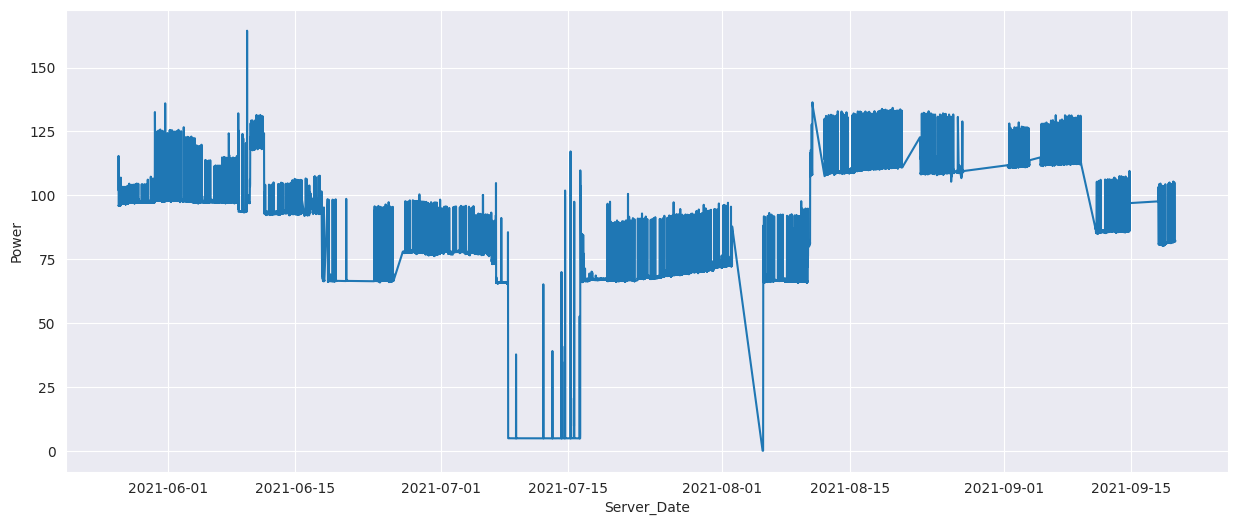

In [12]:
# plot the target variable
plt.figure(figsize = (15, 6))
# Now plot
sns.lineplot(data=sensor_df10m, x='Server_Date', y='Power')
plt.show()

## Modeling

## Time Series Forecasting: Power Prediction for the Next Hour  

In this section, we will explore various models to forecast **power consumption** for the next **1 hour**. Since our data includes **timestamps**, this problem falls under **time series forecasting**. We will experiment with specialized time series models to identify the most effective approach.  

### Models to be Explored  

#### 1️. **FBProphet**  
- Developed by Facebook, **FBProphet** is a powerful time series forecasting model.  
- It performs well on structured time-dependent data and can capture seasonality and trends efficiently.  

#### 2️. **LSTM (Long Short-Term Memory)**  
- A type of **recurrent neural network (RNN)** that excels in time series forecasting.  
- It can learn complex dependencies and patterns from sequential data.  

#### 3️. **LSTM Autoencoders**  
- An advanced **deep learning model** based on an **encoder-decoder architecture**.  
- Uses **LSTM layers** to extract latent features from the time series data, improving prediction accuracy.  

###  **Exploring Alternative Approaches**  
If deep learning models fail to deliver optimal results, we will explore **machine learning techniques** such as:  
- **Random Forest Regressor**  
- **Gradient Boosting Models (XGBoost, )**   

By experimenting with these models, we aim to build a robust forecasting solution for power prediction. 


## FBprophet

19:39:27 - cmdstanpy - INFO - Chain [1] start processing
19:39:32 - cmdstanpy - INFO - Chain [1] done processing


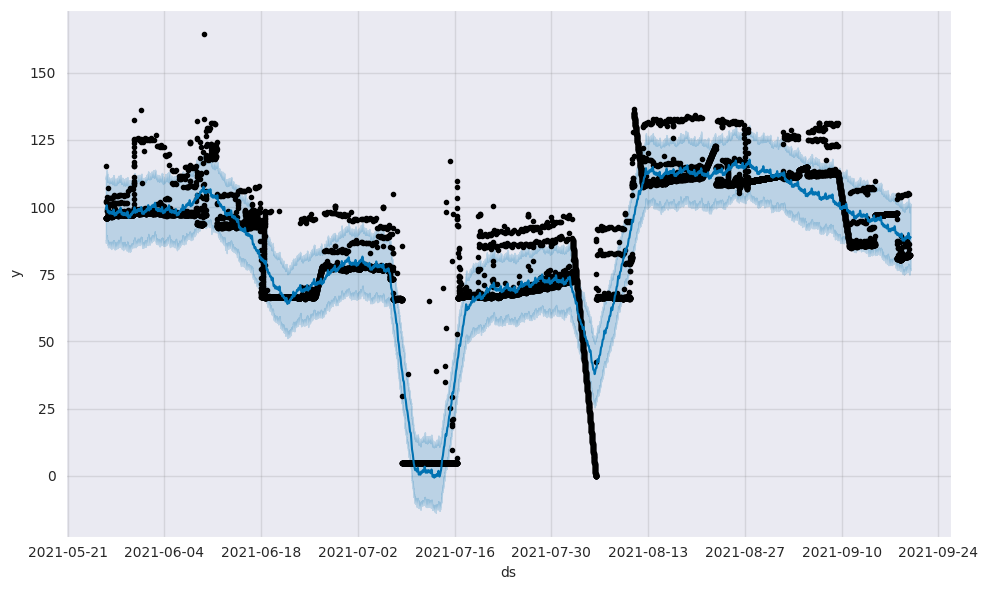

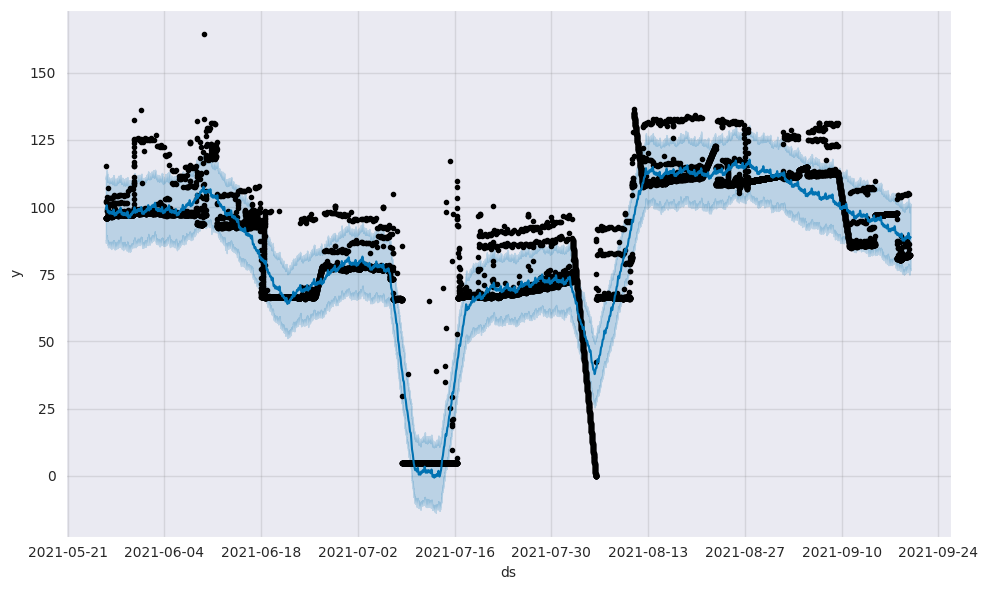

In [18]:
# Ensure the timestamp is in datetime format
sensor_df10m['Server_Date'] = pd.to_datetime(sensor_df10m['Server_Date'])

# Prepare the data for Prophet
df_prophet = sensor_df10m[['Server_Date', 'Power']].rename(columns={'Server_Date': 'ds', 'Power': 'y'})


model = Prophet()
  
# Fit the model
model.fit(df_prophet)

# Make a dataframe for future dates (next 3 hours)
future = model.make_future_dataframe(periods=3, freq='h')  # Corrected line

# Forecast the future power values
forecast = model.predict(future)

# # Plot the forecast
model.plot(forecast)


### LSTM

In [13]:
# Ensure Server_Date is in datetime format
sensor_df10m['Server_Date'] = pd.to_datetime(sensor_df10m['Server_Date'], format='%d-%m-%Y %H:%M', dayfirst=True)

# Select relevant columns (EXCLUDE 'Server_Date' from feature scaling)
feature_cols = ['Voltage', 'Frequency', 'Energy', 'Power_Factor', 'sin_hour', 'day', 'day_of_week']
target_col = 'Power'

# Normalize data for features
scaler_features = MinMaxScaler()
df_features_scaled = pd.DataFrame(scaler_features.fit_transform(sensor_df10m[feature_cols]),
                                  columns=feature_cols)

# Ensure target column remains a DataFrame and is converted to numpy
df_target = sensor_df10m[[target_col]].values  # Convert to numpy array

# Convert to numpy array and horizontally stack features + target
data_array = np.hstack((df_features_scaled.values, df_target))

# Function to create sequences for time series forecasting
def create_sequences_multivariate(data, input_steps=6, output_steps=1):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i : i + input_steps, :])  # Past input_steps data points
        y.append(data[i + input_steps : i + input_steps + output_steps, -1])  # Next output_steps target values
    return np.array(X), np.array(y)

# Create sequences
input_steps, output_steps = 6, 1
X, y = create_sequences_multivariate(data_array, input_steps, output_steps)

# Split data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")


Shapes - X_train: (13392, 6, 8), X_test: (3349, 6, 8), y_train: (13392, 1), y_test: (3349, 1)


In [14]:
# Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(input_steps, X_train.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(output_steps)
])

model.compile(optimizer='adam', loss='mse')

# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict next 1 hour
y_pred = model.predict(X_test)


print("Predicted Next Hour Power Consumption (first example):", y_pred[0])

Epoch 1/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 4011.1343 - val_loss: 190.9427
Epoch 2/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 69.4310 - val_loss: 12.0699
Epoch 3/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 28.6884 - val_loss: 10.4378
Epoch 4/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 21.8607 - val_loss: 11.3656
Epoch 5/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 26.5070 - val_loss: 10.3894
Epoch 6/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 22.1161 - val_loss: 9.6290
Epoch 7/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 23.2441 - val_loss: 10.5909
Epoch 8/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 19.1047 - val_loss: 11.0894
Epoch 9/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 20.3867 - val_loss: 9.3018
Epoch 10/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 18.3855 - val_loss: 8.8752
Epoch 11/50
419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 19.9439 - val_loss: 8.7907
Epoch 12/50
419/419 

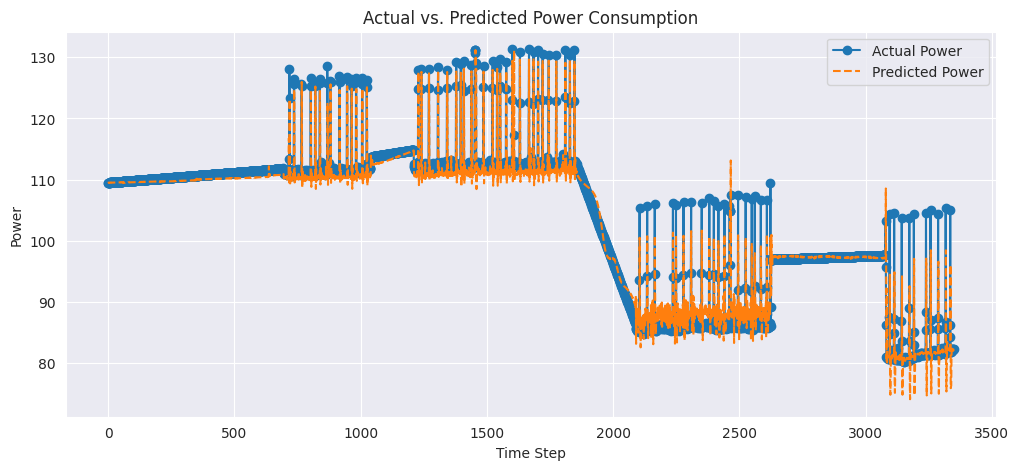

In [15]:
# Select a sample range to visualize
plt.figure(figsize=(12, 5))
plt.plot(y_test.flatten(), label="Actual Power", marker='o')
plt.plot(y_pred.flatten(), label="Predicted Power", linestyle="dashed")

plt.xlabel("Time Step")
plt.ylabel("Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.grid(True)
plt.show()


419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


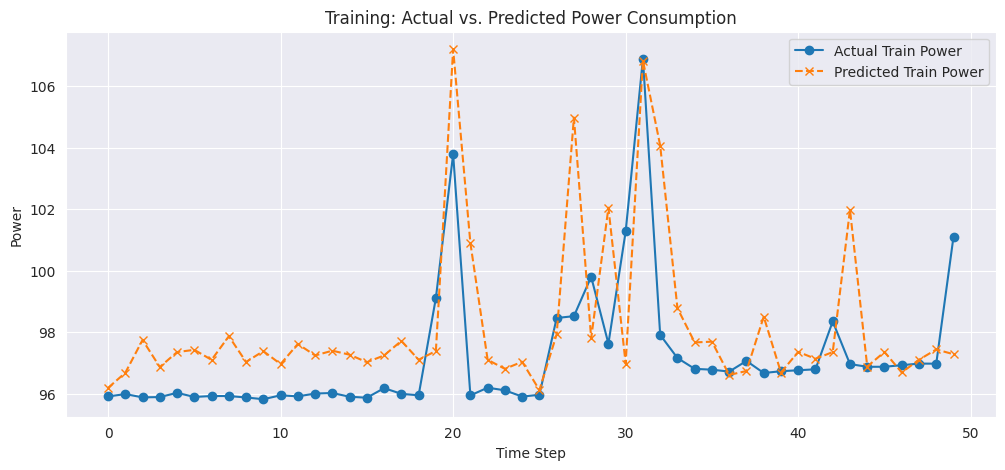

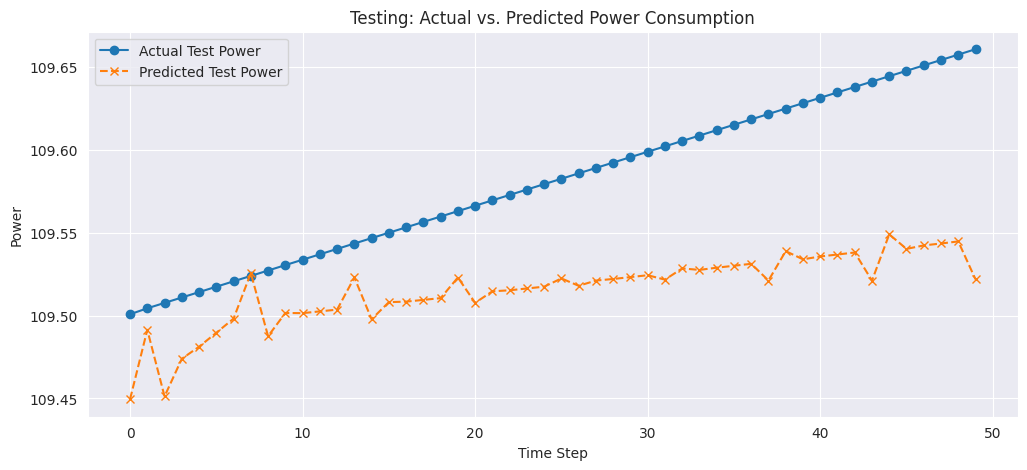

In [16]:
# Get predictions for the training set
y_train_pred = model.predict(X_train)

# Plot actual vs predicted for training data
plt.figure(figsize=(12, 5))
plt.plot(y_train[:50].flatten(), label="Actual Train Power", marker='o')
plt.plot(y_train_pred[:50].flatten(), label="Predicted Train Power", linestyle="dashed", marker='x')
plt.xlabel("Time Step")
plt.ylabel("Power")
plt.title("Training: Actual vs. Predicted Power Consumption")
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted for test data
plt.figure(figsize=(12, 5))
plt.plot(y_test[:50].flatten(), label="Actual Test Power", marker='o')
plt.plot(y_pred[:50].flatten(), label="Predicted Test Power", linestyle="dashed", marker='x')
plt.xlabel("Time Step")
plt.ylabel("Power")
plt.title("Testing: Actual vs. Predicted Power Consumption")
plt.legend()
plt.grid(True)
plt.show()


### LSTM-Autoencoders

In [17]:
# **Step 1: Train LSTM Autoencoder for Feature Extraction**
latent_dim = 8  # Compressed representation size
num_features = X_train.shape[2]  # Number of input features

input_layer = Input(shape=(input_steps, num_features))
encoded = LSTM(64, return_sequences=True)(input_layer)
encoded = LSTM(32, return_sequences=False)(encoded)
encoded = Dense(latent_dim, activation='relu')(encoded)

decoded = RepeatVector(input_steps)(encoded)
decoded = LSTM(32, return_sequences=True)(decoded)
decoded = LSTM(64, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(num_features))(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_test, X_test))

encoder = Model(input_layer, encoded)

# **Step 2: Use Encoded Features for Forecasting**
forecast_input = Input(shape=(latent_dim,))
forecast_output = Dense(32, activation='relu')(forecast_input)
forecast_output = Dense(output_steps)(forecast_output)  # Predict 6 future power values
forecast_model = Model(forecast_input, forecast_output)
forecast_model.compile(optimizer='adam', loss='mse')

# Prepare encoded representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Train Forecasting Model
forecast_model.fit(X_train_encoded, y_train, epochs=100, batch_size=64, validation_data=(X_test_encoded, y_test))

# Predict next 1 hour
y_pred = forecast_model.predict(X_test_encoded)


print("Predicted Next Hour Power Consumption (first example):", y_pred[0])


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 749.6074 - val_loss: 796.2906
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 439.9975 - val_loss: 568.1132
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 292.1223 - val_loss: 406.9437
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 198.4542 - val_loss: 291.7015
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 131.6968 - val_loss: 210.5490
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 94.3212 - val_loss: 155.0193
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 70.1080 - val_loss: 115.4851
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 49.9033 - val_loss: 84.4648
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 35.7134 - val_loss: 62.1784
Epoch 10/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 26.7856 - val_loss: 46.2500
Epoch 11/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 19.8423 - val_loss: 35.1367
Epoch 12

## ML models

## Exploring Machine Learning for Power Prediction  

After experimenting with **deep learning** and **advanced models**, we observed that these approaches are not performing well on our dataset. The models fail to produce **reliable forecasts**, indicating the need for a different strategy.  

### **Switching to Machine Learning with Feature Engineering**  
To enhance model performance, we will incorporate **feature engineering** by generating new features such as:  
- **Lag features** – capturing past values to identify trends.  
- **Trend features** – detecting seasonal patterns and fluctuations.  
- **Hourly power consumption** – leveraging time-based dependencies.  

### **New ML Approaches**  
We will begin by testing two powerful **machine learning models**:  
1️. **Random Forest Regressor**  
2️. **XGBoost Regressor**  

If these models demonstrate promising results, we will further refine them using **optimization techniques** to improve accuracy and reliability.  


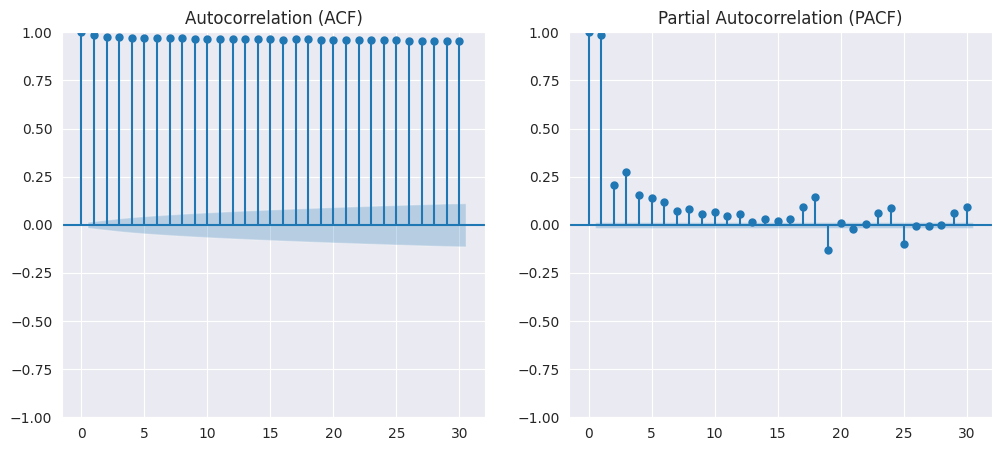

In [19]:
# Plot ACF and PACF for Power
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(sensor_df10m['Power'], ax=axes[0], lags=30)  # Adjust lags based on data frequency
plot_pacf(sensor_df10m['Power'], ax=axes[1], lags=30)

axes[0].set_title("Autocorrelation (ACF)")
axes[1].set_title("Partial Autocorrelation (PACF)")
plt.show()


In [20]:
# Adding new features in form of lags, our understanding and experiments suggest that we can have 10-12 lags
sensor_df10m_v1 = sensor_df10m.copy()
lag_features = 12
for lag in range(1, lag_features + 1):
    sensor_df10m_v1[f'Power_lag_{lag}'] = sensor_df10m_v1['Power'].shift(lag)

# Drop rows with NaN values created due to shifting
sensor_df10m_v1 = sensor_df10m_v1.dropna().set_index('Server_Date')

# Display the first few rows
sensor_df10m_v1.head()


,Voltage,Power,Frequency,Energy,Power_Factor,sin_hour,day,day_of_week,Power_lag_1,Power_lag_2,Power_lag_3,Power_lag_4,Power_lag_5,Power_lag_6,Power_lag_7,Power_lag_8,Power_lag_9,Power_lag_10,Power_lag_11,Power_lag_12
Server_Date,,,,,,,,,,,,,,,,,,,,
2021-05-26 15:00:00,120.024852,95.920207,59.929887,47.6900,0.859525,-0.707107,26,2,95.889922,96.024292,95.886028,95.876458,95.983083,95.905531,95.794542,96.064477,95.869542,102.378651,115.386556,101.921487
2021-05-26 15:10:00,120.038583,95.919000,59.957625,47.7055,0.859379,-0.707107,26,2,95.920207,95.889922,96.024292,95.886028,95.876458,95.983083,95.905531,95.794542,96.064477,95.869542,102.378651,115.386556
2021-05-26 15:20:00,120.029510,95.873187,59.949168,47.7215,0.858604,-0.707107,26,2,95.919000,95.920207,95.889922,96.024292,95.886028,95.876458,95.983083,95.905531,95.794542,96.064477,95.869542,102.378651
2021-05-26 15:30:00,120.043091,95.815872,59.970906,47.7360,0.859702,-0.707107,26,2,95.873187,95.919000,95.920207,95.889922,96.024292,95.886028,95.876458,95.983083,95.905531,95.794542,96.064477,95.869542
2021-05-26 15:40:00,120.036500,95.943263,59.958708,47.7542,0.859467,-0.707107,26,2,95.815872,95.873187,95.919000,95.920207,95.889922,96.024292,95.886028,95.876458,95.983083,95.905531,95.794542,96.064477


In [21]:
# Evaluation Function with More Metrics
def evaluate_model(y_true, y_pred, model_name, dataset_name, num_features):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    # MAPE Calculation (Avoid division by zero)
    MAPE = mean_absolute_percentage_error(y_true, y_pred) * 100 if np.any(y_true != 0) else None

    # Adjusted R² Calculation
    n = len(y_true)  # Number of samples
    p = num_features  # Number of features used in the model
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else None

    print(f"{model_name} ({dataset_name}) - RMSE: {rmse:.6f}, R²: {r2:.6f}, "
          f"Adjusted R²: {adjusted_r2:.6f}" if adjusted_r2 is not None else "N/A", 
          f"MAE: {mae:.6f}, MAPE: {MAPE:.2f}%" if MAPE is not None else "MAPE: N/A")

In [22]:
# Split the dataset into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(sensor_df10m))
train_df = sensor_df10m_v1.iloc[:train_size]
test_df = sensor_df10m_v1.iloc[train_size:]

X_train, y_train = train_df.drop(columns=['Power']), train_df['Power']
X_test, y_test = test_df.drop(columns=['Power']), test_df['Power']

#  Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

#  Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

#  Predictions for Train and Test Data
rf_pred_train_base = rf_model.predict(X_train)
rf_pred_test_base = rf_model.predict(X_test)

xgb_pred_train_base = xgb_model.predict(X_train)
xgb_pred_test_base = xgb_model.predict(X_test)

num_features = X_train.shape[1]  # Number of independent variables

#  Evaluate on Training Random-forest model
evaluate_model(y_train, rf_pred_train_base, "Random Forest", "Train", num_features)
evaluate_model(y_test, rf_pred_test_base, "Random Forest", "Test", num_features)

print('\n', '- '* 50, '\n')

#  Evaluate on XGB model
evaluate_model(y_train, xgb_pred_train_base, "XGBoost", "Train", num_features)
evaluate_model(y_test, xgb_pred_test_base, "XGBoost", "Test", num_features)


Random Forest (Train) - RMSE: 1.536000, R²: 0.997378, Adjusted R²: 0.997374 MAE: 0.480112, MAPE: 288555403076505.62%
Random Forest (Test) - RMSE: 5.234009, R²: 0.809033, Adjusted R²: 0.807939 MAE: 3.490194, MAPE: 3.78%

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

XGBoost (Train) - RMSE: 1.740738, R²: 0.996632, Adjusted R²: 0.996628 MAE: 0.726516, MAPE: 364605645257109.81%
XGBoost (Test) - RMSE: 3.637992, R²: 0.907740, Adjusted R²: 0.907212 MAE: 2.047759, MAPE: 2.03%


We can notice that Both ML approaches are surpassing our Deep learning and Time series models. That's a good thing. Let now try to apply hyperparameter tuning and see how much we are able to improve as we still are overfitting on training data.

## Hyperparameter tuning

In [23]:


# 🟢 Train a Random Forest model
rf_model = rf_model = RandomForestRegressor(
    n_estimators=200,  # Reduce trees
    max_depth=15,  # Limit depth
    min_samples_split=5,  # Prevent overfitting
    min_samples_leaf=4,
    random_state=42)
rf_model.fit(X_train, y_train)

# 🟢 Train an XGBoost model
xgb_model = xgb_model = XGBRegressor(
    n_estimators=200,  # Reduce trees
    learning_rate=0.03,  # Lower learning rate
    max_depth=10,  # Limit depth
    reg_lambda=10,  # Add L2 regularization
    gamma=0.1,  # Prune weak trees
    subsample=0.8,  # Use 80% of data per tree
    colsample_bytree=0.8,  # Use 80% of features
    random_state=42)

xgb_model.fit(X_train, y_train)

# 🟢 Predictions for Train and Test Data
rf_pred_train_tuned = rf_model.predict(X_train)
rf_pred_test_tuned = rf_model.predict(X_test)

xgb_pred_train_tuned = xgb_model.predict(X_train)
xgb_pred_test_tuned = xgb_model.predict(X_test)


num_features = X_train.shape[1]  # Number of independent variables

# 🟢 Evaluate on Random forest model
evaluate_model(y_train, rf_pred_train_tuned, "Random Forest", "Train", num_features)
evaluate_model(y_test, rf_pred_test_tuned, "Random Forest", "Test", num_features)

print('\n', '- '* 50, '\n')
# 🟢 Evaluate on XGB model
evaluate_model(y_train, xgb_pred_train_tuned, "XGBoost", "Train", num_features)
evaluate_model(y_test, xgb_pred_test_tuned, "XGBoost", "Test", num_features)


Random Forest (Train) - RMSE: 2.910169, R²: 0.990588, Adjusted R²: 0.990574 MAE: 0.883796, MAPE: 273517020063084.62%
Random Forest (Test) - RMSE: 3.120450, R²: 0.932123, Adjusted R²: 0.931734 MAE: 1.416970, MAPE: 1.40%

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

XGBoost (Train) - RMSE: 2.540574, R²: 0.992827, Adjusted R²: 0.992816 MAE: 0.871789, MAPE: 1195570215863822.00%
XGBoost (Test) - RMSE: 4.176955, R²: 0.878379, Adjusted R²: 0.877682 MAE: 2.752644, MAPE: 2.59%


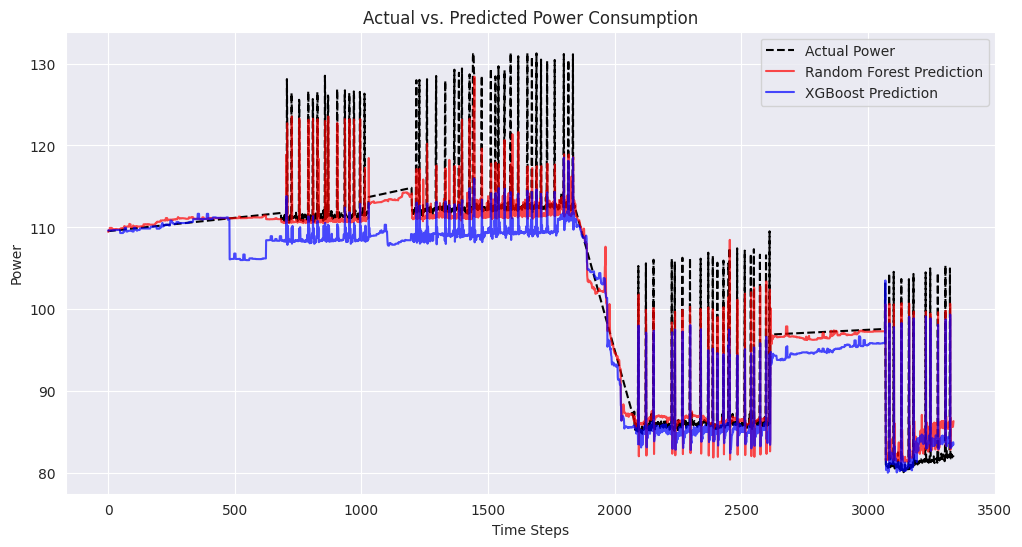

In [24]:
# 🟢 Line Plot: Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Power", color="black", linestyle="dashed")
plt.plot(rf_pred_test_tuned, label="Random Forest Prediction", color="red", alpha=0.7)
plt.plot(xgb_pred_test_tuned, label="XGBoost Prediction", color="blue", alpha=0.7)

plt.xlabel("Time Steps")
plt.ylabel("Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.show()

Results: We can see improve results but stil not as great as we want have. We can see that both models are underestimating the forecasts. Let's apply some feature engineering technique by building up few new features and see how much we are improving.

## Applying some data engineering

In [25]:
power_df_10m = sensor_df10m_v1.copy()

# Compute moving average for last 1-hour (6 time steps)
power_df_10m['Power_MA_1h'] = power_df_10m['Power'].rolling(window=6).mean()

# Compute moving standard deviation for last 1-hour (6 time steps)
power_df_10m['Power_Std_1h'] = power_df_10m['Power'].rolling(window=6).std()

# Compute rate of change (difference between current power and moving average)
power_df_10m['Power_Trend_1h'] = power_df_10m['Power'] - power_df_10m['Power_MA_1h']

# Fill NaN values resulting from rolling calculations (optional, based on your model)
power_df_10m.bfill(inplace=True)

# Display updated dataframe
power_df_10m.head()


,Voltage,Power,Frequency,Energy,Power_Factor,sin_hour,day,day_of_week,Power_lag_1,Power_lag_2,...,Power_lag_6,Power_lag_7,Power_lag_8,Power_lag_9,Power_lag_10,Power_lag_11,Power_lag_12,Power_MA_1h,Power_Std_1h,Power_Trend_1h
Server_Date,,,,,,,,,,,,,,,,,,,,,
2021-05-26 15:00:00,120.024852,95.920207,59.929887,47.6900,0.859525,-0.707107,26,2,95.889922,96.024292,...,95.905531,95.794542,96.064477,95.869542,102.378651,115.386556,101.921487,95.896732,0.045721,0.012133
2021-05-26 15:10:00,120.038583,95.919000,59.957625,47.7055,0.859379,-0.707107,26,2,95.920207,95.889922,...,95.983083,95.905531,95.794542,96.064477,95.869542,102.378651,115.386556,95.896732,0.045721,0.012133
2021-05-26 15:20:00,120.029510,95.873187,59.949168,47.7215,0.858604,-0.707107,26,2,95.919000,95.920207,...,95.876458,95.983083,95.905531,95.794542,96.064477,95.869542,102.378651,95.896732,0.045721,0.012133
2021-05-26 15:30:00,120.043091,95.815872,59.970906,47.7360,0.859702,-0.707107,26,2,95.873187,95.919000,...,95.886028,95.876458,95.983083,95.905531,95.794542,96.064477,95.869542,95.896732,0.045721,0.012133
2021-05-26 15:40:00,120.036500,95.943263,59.958708,47.7542,0.859467,-0.707107,26,2,95.815872,95.873187,...,96.024292,95.886028,95.876458,95.983083,95.905531,95.794542,96.064477,95.896732,0.045721,0.012133


In [26]:
# Split the dataset into train and test sets (80% train, 20% test)
train_ratio = int(0.8 * len(power_df_10m))
train_df_MA = power_df_10m.iloc[:train_ratio]
test_df_MA = power_df_10m.iloc[train_ratio:]

X_train_MA, y_train_MA = train_df_MA.drop(columns=['Power']), train_df_MA['Power']
X_test_MA, y_test_MA = test_df_MA.drop(columns=['Power']), test_df_MA['Power']



## XGBoost

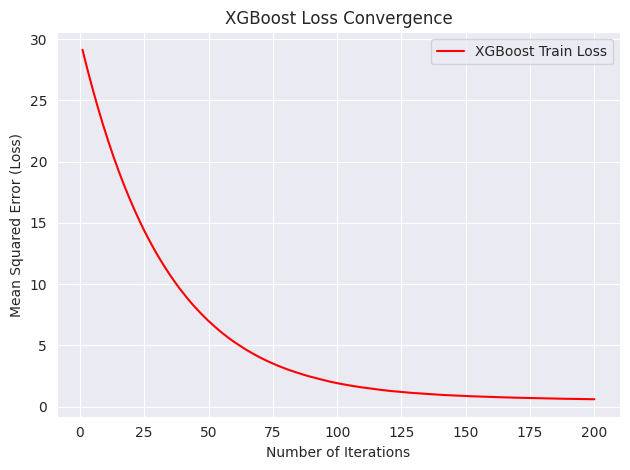

In [28]:
# Train an XGBoost model with eval_set to monitor convergence
xgb_model_MA = XGBRegressor(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=10,
    reg_lambda=10,
    gamma=0.8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="rmse",  # Set eval_metric in constructor
    early_stopping_rounds=10  # Set early_stopping_rounds in constructor
)

# Track the training loss for each iteration
evals = [(X_train_MA, y_train_MA)]  # List of tuples with training set

# Train the model with eval_set
xgb_model_MA.fit(X_train_MA, y_train_MA, eval_set=evals, verbose=False)

# Extract training loss history from XGBoost training
evals_result = xgb_model_MA.evals_result()  # This is now the correct call
train_mse_xgb = evals_result['validation_0']['rmse']

# Plot for XGBoost (only training loss)
plt.plot(range(1, len(train_mse_xgb) + 1), train_mse_xgb, label="XGBoost Train Loss", color='r')
plt.xlabel('Number of Iterations')  # Corrected line
plt.ylabel('Mean Squared Error (Loss)')
plt.title('XGBoost Loss Convergence')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [29]:
XGB_MA_train_preds  = xgb_model_MA.predict(X_train_MA)
XGB_MA_test_preds  = xgb_model_MA.predict(X_test_MA)


num_features = X_train_MA.shape[1]
print('\n', '- '* 50, '\n')
# 🟢 Evaluate on XGB model
evaluate_model(y_train_MA, XGB_MA_train_preds, "XGBoost", "Train", num_features)
evaluate_model(y_test_MA, XGB_MA_test_preds, "XGBoost", "Test", num_features)


 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

XGBoost (Train) - RMSE: 0.599163, R²: 0.999601, Adjusted R²: 0.999600 MAE: 0.186783, MAPE: 595941341130032.00%
XGBoost (Test) - RMSE: 1.137376, R²: 0.990963, Adjusted R²: 0.990904 MAE: 0.809747, MAPE: 0.77%


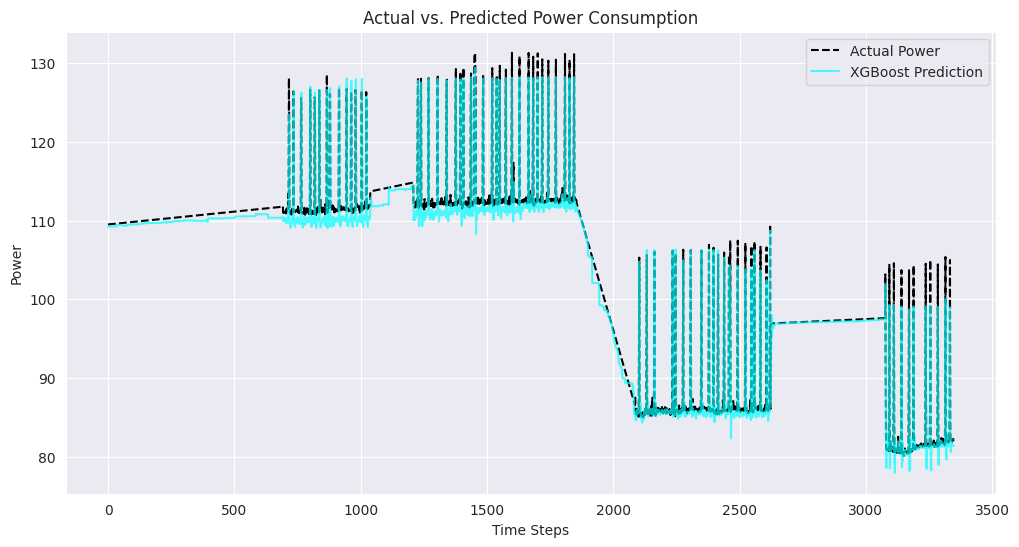

In [30]:
#  Line Plot: Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_MA.values, label="Actual Power", color="black", linestyle="dashed")
plt.plot(XGB_MA_test_preds, label="XGBoost Prediction", color="cyan", alpha=0.7)

plt.xlabel("Time Steps")
plt.ylabel("Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.show()

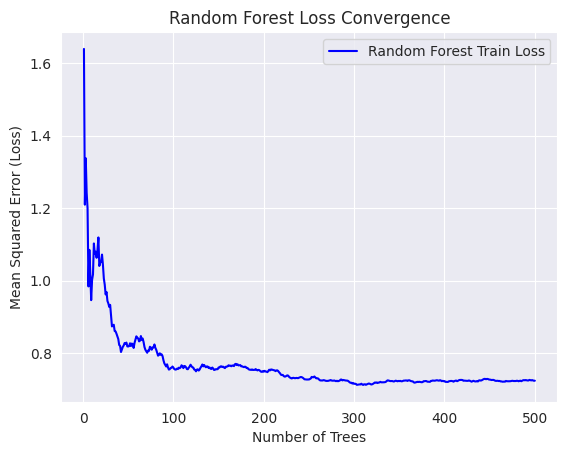

In [33]:
# Train a Random Forest model with warm_start to monitor convergence
rf_model_MA = RandomForestRegressor(
    n_estimators=1,  # Start with 1 tree
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42,
    warm_start=True  # This will allow us to track the loss as trees are added
)

train_mse_rf = []  # List to store MSE for each iteration

# Incrementally train the model and track loss
for i in range(1, 501):  # Iterate over 200 trees
    rf_model_MA.n_estimators = i  # Increase the number of trees
    rf_model_MA.fit(X_train_MA, y_train_MA)  # Train model incrementally
    
    # Track training loss
    rf_pred_train_MA = rf_model_MA.predict(X_train_MA)
    mse_train = mean_squared_error(y_train_MA, rf_pred_train_MA)
    train_mse_rf.append(mse_train)

# Plot for Random Forest (only training loss)
plt.plot(range(1, 501), train_mse_rf, label="Random Forest Train Loss", color='b')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error (Loss)')
plt.title('Random Forest Loss Convergence')
plt.legend()
plt.show()


In [34]:
RF_MA_train_preds  = rf_model_MA.predict(X_train_MA)
RF_MA_test_preds  = rf_model_MA.predict(X_test_MA)


num_features = X_train_MA.shape[1]
print('\n', '- '* 50, '\n')
# Evaluate on XGB model
evaluate_model(y_train_MA, RF_MA_train_preds, "Random forest", "Train", num_features)
evaluate_model(y_test_MA, RF_MA_test_preds, "Random", "Test", num_features)


 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Random forest (Train) - RMSE: 0.850401, R²: 0.999196, Adjusted R²: 0.999195 MAE: 0.143346, MAPE: 17984012241212.66%
Random (Test) - RMSE: 1.094439, R²: 0.991633, Adjusted R²: 0.991577 MAE: 0.676962, MAPE: 0.69%


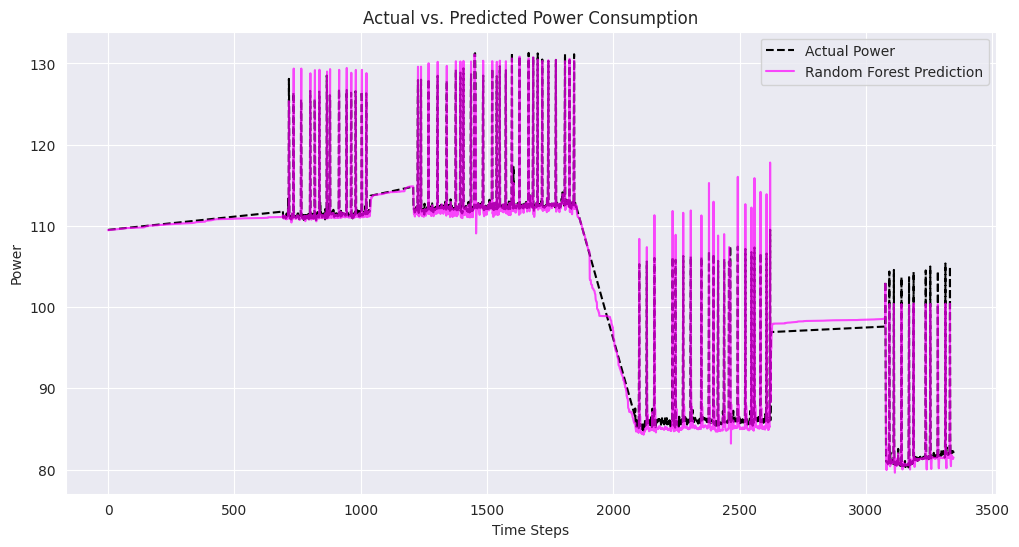

In [35]:
#  Line Plot: Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_MA.values, label="Actual Power", color="black", linestyle="dashed")
plt.plot(RF_MA_test_preds, label="Random Forest Prediction", color="magenta", alpha=0.7)


plt.xlabel("Time Steps")
plt.ylabel("Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.show()


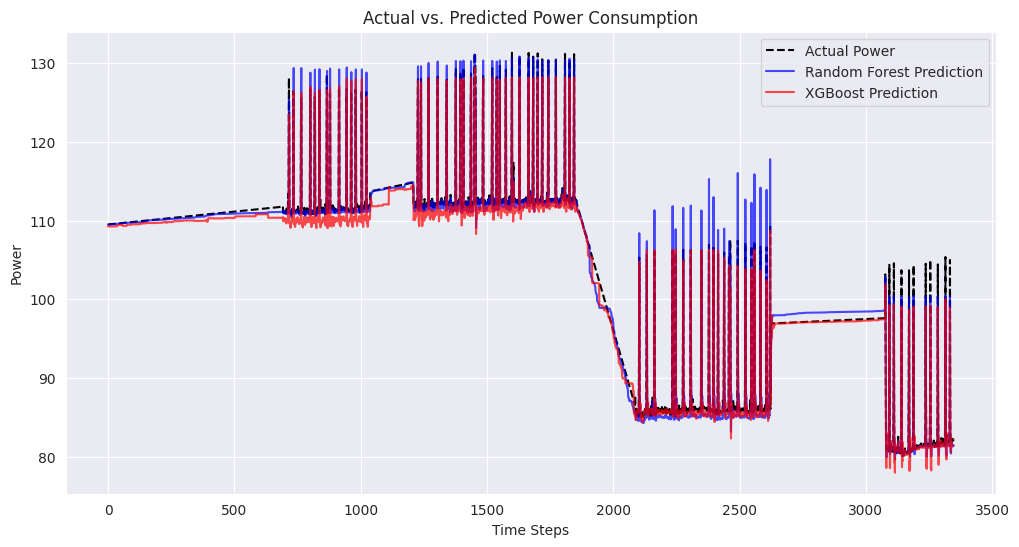

In [36]:
#  Line Plot: Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_MA.values, label="Actual Power", color="black", linestyle="dashed")
plt.plot(RF_MA_test_preds, label="Random Forest Prediction", color="blue", alpha=0.7)
plt.plot(XGB_MA_test_preds, label="XGBoost Prediction", color="red", alpha=0.7)

plt.xlabel("Time Steps")
plt.ylabel("Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.show()



## 🚀 Moving Closer to Accurate Predictions!  

Great news! We are seeing **improved results**, and we’re almost there! 🎉  

### 🔍 **Key Observations:**  
- **XGBoost** tends to **underestimate** the predictions.  
- **Random Forest** tends to **overestimate** the predictions.  

To strike a balance, we will take the **average of both models' predictions** as our final forecast. This ensemble approach will help mitigate individual model biases and enhance overall accuracy.  

This marks a **significant step in the right direction**, bringing us closer to a **reliable** and **robust** forecasting model. ✅  


## Final prediction model

In [37]:
def ensemble_predict(X_input):
    """
    Generate predictions using both XGBoost and Random Forest models
    and return the averaged predictions.
    
    Args:
        X_input (numpy array or DataFrame): The input features.
    
    Returns:
        numpy array: The averaged predictions.
    """
    xgb_preds = xgb_model_MA.predict(X_input)
    rf_preds = rf_model_MA.predict(X_input)
    
    final_preds = (xgb_preds + rf_preds) / 2  # Averaging predictions
    return final_preds

# Example usage:
final_test_preds = ensemble_predict(X_test_MA)

# Evaluate the ensemble model
evaluate_model(y_test_MA, final_test_preds, "Ensemble (XGBoost + Random Forest)", "Test", num_features)


Ensemble (XGBoost + Random Forest) (Test) - RMSE: 0.948545, R²: 0.993715, Adjusted R²: 0.993673 MAE: 0.686738, MAPE: 0.67%


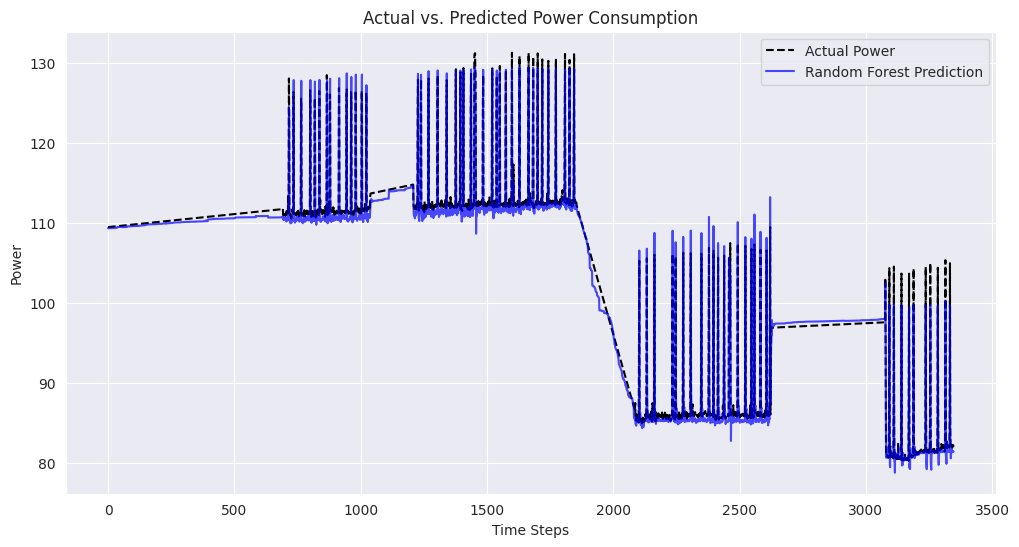

In [38]:
#  Line Plot: Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_MA.values, label="Actual Power", color="black", linestyle="dashed")
plt.plot(final_test_preds, label="Random Forest Prediction", color="blue", alpha=0.7)


plt.xlabel("Time Steps")
plt.ylabel("Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.show()


## combining the dataset with predictions

In [39]:
final_train_preds = ensemble_predict(X_train_MA)

final_train_df = train_df_MA.copy()
final_train_df['Power_Prediction'] = final_train_preds
final_train_df['Type'] = 'train'

In [40]:
final_test_preds = ensemble_predict(X_test_MA)

final_test_df = test_df_MA.copy()
final_test_df['Power_Prediction'] = final_test_preds
final_test_df['Type'] = 'test'

In [41]:
final_train_df.head()

,Voltage,Power,Frequency,Energy,Power_Factor,sin_hour,day,day_of_week,Power_lag_1,Power_lag_2,...,Power_lag_8,Power_lag_9,Power_lag_10,Power_lag_11,Power_lag_12,Power_MA_1h,Power_Std_1h,Power_Trend_1h,Power_Prediction,Type
Server_Date,,,,,,,,,,,,,,,,,,,,,
2021-05-26 15:00:00,120.024852,95.920207,59.929887,47.6900,0.859525,-0.707107,26,2,95.889922,96.024292,...,96.064477,95.869542,102.378651,115.386556,101.921487,95.896732,0.045721,0.012133,95.786212,train
2021-05-26 15:10:00,120.038583,95.919000,59.957625,47.7055,0.859379,-0.707107,26,2,95.920207,95.889922,...,95.794542,96.064477,95.869542,102.378651,115.386556,95.896732,0.045721,0.012133,95.781749,train
2021-05-26 15:20:00,120.029510,95.873187,59.949168,47.7215,0.858604,-0.707107,26,2,95.919000,95.920207,...,95.905531,95.794542,96.064477,95.869542,102.378651,95.896732,0.045721,0.012133,95.763548,train
2021-05-26 15:30:00,120.043091,95.815872,59.970906,47.7360,0.859702,-0.707107,26,2,95.873187,95.919000,...,95.983083,95.905531,95.794542,96.064477,95.869542,95.896732,0.045721,0.012133,95.711683,train
2021-05-26 15:40:00,120.036500,95.943263,59.958708,47.7542,0.859467,-0.707107,26,2,95.815872,95.873187,...,95.876458,95.983083,95.905531,95.794542,96.064477,95.896732,0.045721,0.012133,95.764339,train


In [42]:
final_test_df.head()

,Voltage,Power,Frequency,Energy,Power_Factor,sin_hour,day,day_of_week,Power_lag_1,Power_lag_2,...,Power_lag_8,Power_lag_9,Power_lag_10,Power_lag_11,Power_lag_12,Power_MA_1h,Power_Std_1h,Power_Trend_1h,Power_Prediction,Type
Server_Date,,,,,,,,,,,,,,,,,,,,,
2021-08-27 14:20:00,119.908835,109.507658,59.915707,224.541834,0.899411,-0.500000,27,4,109.504399,109.500810,...,109.294849,109.258540,109.222230,109.185920,109.149610,109.472189,0.042054,0.035469,109.389301,test
2021-08-27 14:30:00,119.906415,109.510917,59.911404,224.527633,0.899572,-0.500000,27,4,109.507658,109.504399,...,109.331159,109.294849,109.258540,109.222230,109.185920,109.490045,0.027385,0.020871,109.357089,test
2021-08-27 14:40:00,119.903994,109.514175,59.907101,224.513432,0.899734,-0.500000,27,4,109.510917,109.507658,...,109.367469,109.331159,109.294849,109.258540,109.222230,109.502393,0.013575,0.011782,109.364619,test
2021-08-27 14:50:00,119.901573,109.517434,59.902797,224.499231,0.899895,-0.500000,27,4,109.514175,109.510917,...,109.403779,109.367469,109.331159,109.294849,109.258540,109.509232,0.006186,0.008202,109.365121,test
2021-08-27 15:00:00,119.900032,109.520693,59.900058,224.497135,0.899999,-0.707107,27,4,109.517434,109.514175,...,109.440089,109.403779,109.367469,109.331159,109.294849,109.512546,0.006096,0.008147,109.367018,test


In [77]:
final_power_preds_df = pd.concat([final_train_df, final_test_df], axis = 0).reset_index()[['Server_Date','Type', 'Power', 'Power_Prediction']]

In [78]:
final_power_preds_df.head()

,Server_Date,Type,Power,Power_Prediction
0,2021-05-26 15:00:00,train,95.920207,95.775349
1,2021-05-26 15:10:00,train,95.919000,95.774755
2,2021-05-26 15:20:00,train,95.873187,95.751460
3,2021-05-26 15:30:00,train,95.815872,95.705962
4,2021-05-26 15:40:00,train,95.943263,95.763383


In [79]:
sensor_df10m.head()

,level_0,index,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor,sin_hour,day,day_of_week
0,0,0,2021-05-26 13:00:00,119.993750,101.921487,59.993750,47.500000,0.881875,-0.258819,26,2
1,1,1,2021-05-26 13:10:00,120.020540,115.386556,59.969136,47.507397,0.864791,-0.258819,26,2
2,2,2,2021-05-26 13:20:00,120.019424,102.378651,59.960309,47.523690,0.864258,-0.258819,26,2
3,3,3,2021-05-26 13:30:00,120.016662,95.869542,59.966538,47.540000,0.864011,-0.258819,26,2
4,4,4,2021-05-26 13:40:00,120.026570,96.064477,59.971062,47.555500,0.865002,-0.258819,26,2


In [80]:
# Merging the train and test dataframes with predictions
final_sensor_power_preds_df = sensor_df10m.merge(final_power_preds_df, on = 'Server_Date', how = 'inner')

In [81]:
final_sensor_power_preds_df.to_csv('final_sensor_power_preds_df.csv', index = False)

In [82]:
final_sensor_power_preds_df.head()

,level_0,index,Server_Date,Voltage,Power_x,Frequency,Energy,Power_Factor,sin_hour,day,day_of_week,Type,Power_y,Power_Prediction
0,12,12,2021-05-26 15:00:00,120.024852,95.920207,59.929887,47.6900,0.859525,-0.707107,26,2,train,95.920207,95.775349
1,13,13,2021-05-26 15:10:00,120.038583,95.919000,59.957625,47.7055,0.859379,-0.707107,26,2,train,95.919000,95.774755
2,14,14,2021-05-26 15:20:00,120.029510,95.873187,59.949168,47.7215,0.858604,-0.707107,26,2,train,95.873187,95.751460
3,15,15,2021-05-26 15:30:00,120.043091,95.815872,59.970906,47.7360,0.859702,-0.707107,26,2,train,95.815872,95.705962
4,16,16,2021-05-26 15:40:00,120.036500,95.943263,59.958708,47.7542,0.859467,-0.707107,26,2,train,95.943263,95.763383
